In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model

In [2]:
# Unfortunately this URL doesn't work directly with pd.read_csv
# !wget -nc https://lazyprogrammer.me/course_files/spam.csv

In [3]:
path = 'C:\\Sandbox\\GitHub\\data\\spam.csv'
# path = tf.keras.utils.get_file('spam.csv', 'https://lazyprogrammer.me/course_files/spam.csv')
print (path)

C:\Sandbox\GitHub\data\spam.csv


In [4]:
df = pd.read_csv(path, encoding='ISO-8859-1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# rename columns to something better
df.columns = ['labels', 'data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [9]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [10]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 7242 unique tokens.


In [11]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (3733, 189)


In [12]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 189)


In [13]:
# Create the model

# We get to choose embedding dimensionality
D = 20

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [14]:
# Compile and fit
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [15]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 189)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 189, 20)           144860    
_________________________________________________________________
conv1d (Conv1D)              (None, 187, 32)           1952      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 62, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 18, 128)          

In [16]:
history = model.fit(
  data_train,
  Ytrain,
  epochs=5,
  validation_data=(data_test, Ytest)
)

Epoch 1/5
117/117 [==============================] - 2s 18ms/step - loss: 0.3989 - accuracy: 0.8580 - val_loss: 0.2832 - val_accuracy: 0.8717
Epoch 2/5
117/117 [==============================] - 2s 15ms/step - loss: 0.1791 - accuracy: 0.9188 - val_loss: 0.1015 - val_accuracy: 0.9625
Epoch 3/5
117/117 [==============================] - 2s 15ms/step - loss: 0.0285 - accuracy: 0.9896 - val_loss: 0.0677 - val_accuracy: 0.9723
Epoch 4/5
117/117 [==============================] - 2s 18ms/step - loss: 0.0062 - accuracy: 0.9992 - val_loss: 0.0601 - val_accuracy: 0.9880
Epoch 5/5
117/117 [==============================] - 2s 18ms/step - loss: 0.0030 - accuracy: 0.9995 - val_loss: 0.0581 - val_accuracy: 0.9891


In [17]:
print(model.metrics_names)

['loss', 'accuracy']


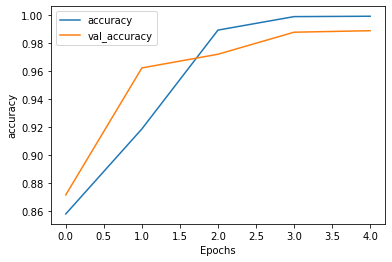

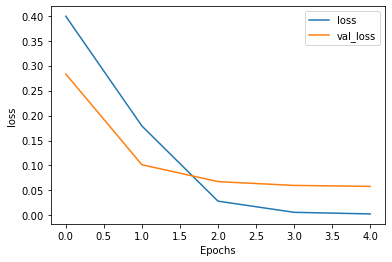

In [18]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [20]:
# Predicting Sentiment in New Reviews Use the model to predict a review   
fake_reviews = ['I love this phone', 'I hate spaghetti', 
                'Everything was cold',
                'Everything was hot exactly as I wanted', 
                'Everything was green', 
                'the host seated us immediately',
                'they gave us free chocolate cake', 
                'not sure about the wilted flowers on the table',
                'only works when I stand on tippy toes',
                'bats are all wearing underwears with tie',
                'bat was runnig the show',
                'does not work when I stand on my head']

print(fake_reviews) 

# Create the sequences

sample_sequences = tokenizer.texts_to_sequences(fake_reviews)
fakes_padded = pad_sequences(sample_sequences, maxlen = T)           

print('\nHOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!\n')              

classes = model.predict(fakes_padded)

# The closer the class is to 1, the more positive the review is deemed to be
for x in range(len(fake_reviews)):
  print(fake_reviews[x])
  np.argmax(print(classes[x]))
  print('\n')

# Try adding reviews of your own
# Add some negative words (such as "not") to the good reviews and see what happens
# For example:
# they gave us free chocolate cake and did not charge us

['I love this phone', 'I hate spaghetti', 'Everything was cold', 'Everything was hot exactly as I wanted', 'Everything was green', 'the host seated us immediately', 'they gave us free chocolate cake', 'not sure about the wilted flowers on the table', 'only works when I stand on tippy toes', 'bats are all wearing underwears with tie', 'bat was runnig the show', 'does not work when I stand on my head']

HOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!

I love this phone
[3.573456e-05]


I hate spaghetti
[0.00241968]


Everything was cold
[0.00011792]


Everything was hot exactly as I wanted
[4.5725254e-05]


Everything was green
[0.00011792]


the host seated us immediately
[0.00442651]


they gave us free chocolate cake
[0.01698926]


not sure about the wilted flowers on the table
[8.43139e-06]


only works when I stand on tippy toes
[1.0392668e-05]


bats are all wearing underwears with tie
[0.00064343]


bat was runnig the show
[7.4924035e-05]


does not work